# Exercise 1

As discussed in Section 1, resizing and rescaling digital images are not trivial operations. There are many ways to resize an image, and one of them is Seam Carving.

The advantage of this method is the content awareness, which enables resizing images while preserving their visual and semantic features.

In this exercise you will:
1. Apply image processing operations as preliminares for later
2. Implement Seam Carving as taught in lecture ([original Seam Carving paper](https://faculty.runi.ac.il/arik/scweb/imret/imret.pdf))
3. Remove explicit objects from images using seam carving
4. Compare the methods in addition to bilinear scaling (no need to implement)


Instructions:
* The notebook is just for displaying your implementation, **do not change code in it**. Changing it might cause failure of our grading unit tests. If you want to change minor things, make sure the original one still runs and display results.
* In `utils.py` we created a template to `SeamImage`,`ColumnSeamImage` and the `SCWithObjRemoval` classes which you will be implementing. Note that if a function does not raise a "NotImplemented exception, it is not mandatory to implement, it is just a suggestion.
* `SeamImage` class is the parent class of the second two. It implements the common functionalities both methods share (the class attributes may help you to manage the metadata of the algorithms).
* `SeamImage` takes an image path and:
    - Loads an RGB image of the original shape
    - Creates a weighted grayscale image and stores it
    - Defines and stores all the required metadata for the Seam Carving algorithm

* `VerticalSeamImage` inherits for `SeamImage`. Its purpose is to:
    - Apply Vertical Seam Carving algorithm (support vertical and horizontal)
    - Track removed seam and later be able to visualize them

* `SCWithObjRemoval` inherits for `VerticalSeamImage`. Its purpose is to:
    - Apply given masks containing objects we would wish to remove
    - Recalculate E and C matrices with respect to the active masks
    - Using its parent functionalities, remove objects by resizing the image in a content-aware manner

* Both methods should implement the **forward-looking** cost matrix $M$
* To get full credit, **you are expected to implement the following as efficient as possible**, and get similar runtime as we report below
* **Tip**: To apply changes from outsides modules into `ipynb` files, restarting the notebook is required when using JIT (will be introduced later). To prevent this, we recommend that you copy here the code and later test it from outside
* When submitting, the notebook must run end to end without any exception raised
* Submission format: **ex01_{student1 first name}-{student1 last name}-{student1 ID}_{student2 first name}-{student2 last name}-{student2 ID}.zip** containing `Seam Carving Assignment.ipynb` (all cells executed from start to end) and your completed `utils.py`. Please stick to this exact format!
* Feel free to ask questions on Piazza. We also highly encourage you to answer questions (but not share code!).


#### After you complete this assignment, you will have a tool to edit any photo you wish.<br>Replace the `img_path` variable, load a photo, edit and upload to your Insta story! 
 ---

Please run the following (install libs if needed) 

In [441]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from PIL import Image
from numba import jit
from utils import *

%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (10,5)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [442]:
img_path = "images/llamas.png"

# helper functions
def read_image(img_path):
    return np.asarray(Image.open(img_path).convert('RGB')).astype('float16')


def show_image(np_img, grayscale=False):
    fig, ax = plt.subplots()
    if not grayscale:
        ax.imshow(np_img, aspect='equal')
    else:
        ax.imshow(np_img, cmap=plt.get_cmap('gray'))
    ax.axis("off")
    plt.show()


def init_plt_grid(nrow=1, ncols=1, figsize=(20,10), **kwargs):
    fig, ax = plt.subplots(nrow, ncols, figsize=figsize, facecolor='gray', **kwargs)
    font_size = dict(size=20)
    return ax, font_size

# run this

def plot_grid(sc_obj):
    ax, font_size = init_plt_grid(ncols=3, figsize=(15,10))

    orig_size = sc_obj.rgb.shape[:2]
    v_pad = (orig_size[0] - sc_obj.h) // 2
    h_pad = (orig_size[1] - sc_obj.w) // 2

    padding_width = ((v_pad, v_pad), (h_pad, h_pad), (0, 0))  # This adds 5 rows/columns of zeros on each side of the image
    padded_img = np.pad(sc_obj.resized_rgb, padding_width, mode='constant', constant_values=0)

    ax[0].set_title('Original Image', **font_size)
    ax[1].set_title('Seam Visualization', **font_size)
    ax[2].set_title('Resized Image', **font_size)

    ax[0].imshow(sc_obj.rgb)
    ax[1].imshow(sc_obj.seams_rgb)
    ax[2].imshow(padded_img)

    # save resized version
    Image.fromarray((sc_obj.resized_rgb*255).astype('uint8')).save('./resized_rgb.jpg')

    for sp in ax.reshape(-1):
        sp.set_xticks([])
        sp.set_yticks([])
    plt.tight_layout()



* * *

### 1. Imaplement SeamImage (20 points)

In [443]:
# TODO: Create a SeamImage instance
s_img = SeamImage(img_path)

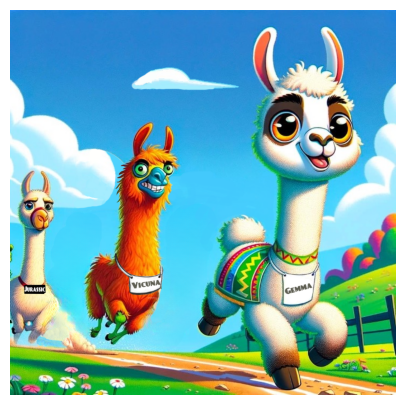

In [444]:
# display sample image we will be working on
show_image(s_img.rgb)

Meet *Gemma*, *Vicuna*, and *Jurassic*. A you can see, **they are in a rase**.

#### Bonus (2 points)
What are they racing for?

**ANSWER**:

Gemma, Vicuna, and Jurassic as Seams: Each character could represent a seam within an image. In seam carving, seams are typically chosen based on their energy, which corresponds to the importance of the pixels in the image. The less important a seam is, the more likely it is to be removed first. The race between the characters could symbolize the process of evaluating which seams (or characters) are the least important and therefore should be 'removed' from the image first to reduce its size without affecting the main content.


In this Excersice we are going to manipulate these three llamas. We are going to make them closer, further from each other and even remove them!
<!-- ![alt text](images/llamas_intr.png "LLMs") -->


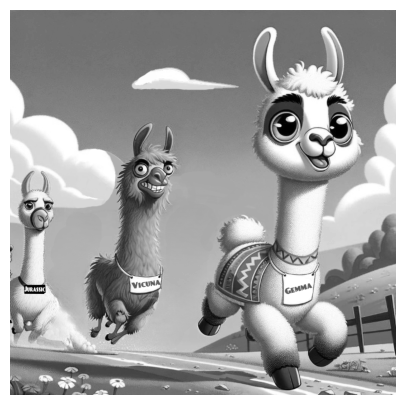

In [445]:
# disply grayscale version
show_image(s_img.gs, grayscale=True)

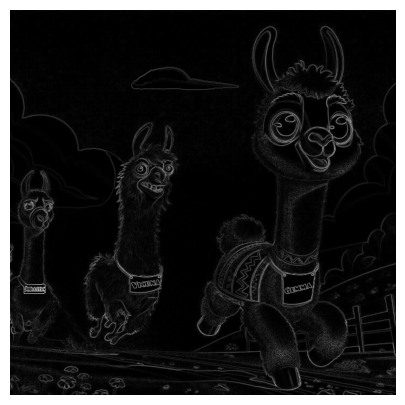

In [446]:
# display its energy (gradient magnitude)
show_image(s_img.E, grayscale=True)

### TODO: Implement VerticalSeamImage class (50 points)

VerticalSeamImage stores an image, and applies vertical Seam Carving. \
This also stores meta data such as: grayscale version, gradient magnitude map, boolean masks indicating if a seam is removed or not, resized versions etc.
Same as above, this class also should support horizontal seam carving.


Guidelines:
* Implement the Energy matrix $M$ as guided
* `VerticalSeamImage.seams_removal_horizontal` and `VerticalSeamImage.seams_removal_horizontal` are wrappers to `VerticalSeamImage.seams_removal` which is the main method where all the magic happens. This process includes:
    * Gradient magnitude of each pixel of self.gs (= self.E)
    * Calculating pixel energy as taught, but with certain terms omitted (= self.M)
    * iterate for *num_remove* times d:
        * Calculate $E$ and $M$ (self.E, self.M respectively)
        * Calculate the dynamic programming matrix
        * Find the minimal seam
        * Remove and update the seam from all metadata matrices
* You are expected to report similar runtime as our implementations
        
*Important: In order to get reasonable runtime, use the Numba decorator by uncommenting `@jit(nopython=True)` above `VerticalSeamImage.calc_bt_mat`*

In [447]:
# TODO: Create a VerticalSeamImage class
vs_img = VerticalSeamImage(img_path=img_path, vis_seams=True)

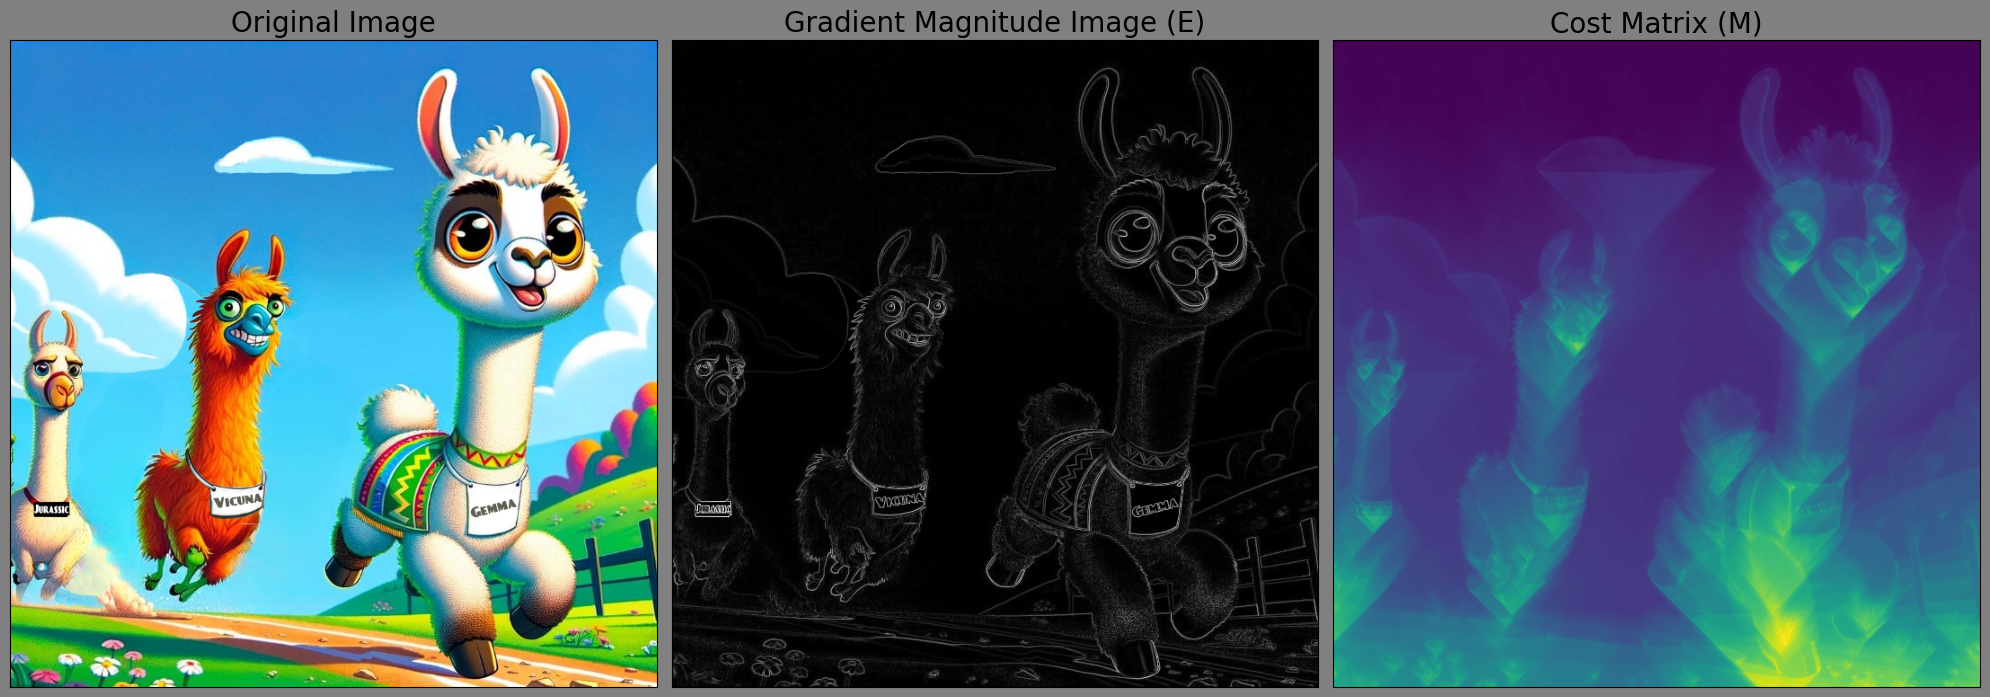

In [448]:
# display matrices

ax, font_size = init_plt_grid(ncols=3)

ax[0].set_title('Original Image', **font_size)
ax[1].set_title('Gradient Magnitude Image (E)', **font_size)
ax[2].set_title('Cost Matrix (M)', **font_size)

ax[0].imshow(vs_img.rgb)
ax[1].imshow(vs_img.E, cmap='gray')
ax[2].imshow(vs_img.M)

for sp in ax.reshape(-1):
    sp.set_xticks([])
    sp.set_yticks([])

plt.tight_layout()

In [449]:
# remove seams (modify as you wish, but keep for submission)
%time vs_img.seams_removal_vertical(100)
%time vs_img.seams_removal_horizontal(100)

CPU times: user 2.86 s, sys: 4.24 ms, total: 2.87 s
Wall time: 2.88 s
CPU times: user 2.91 s, sys: 3.16 ms, total: 2.91 s
Wall time: 2.93 s


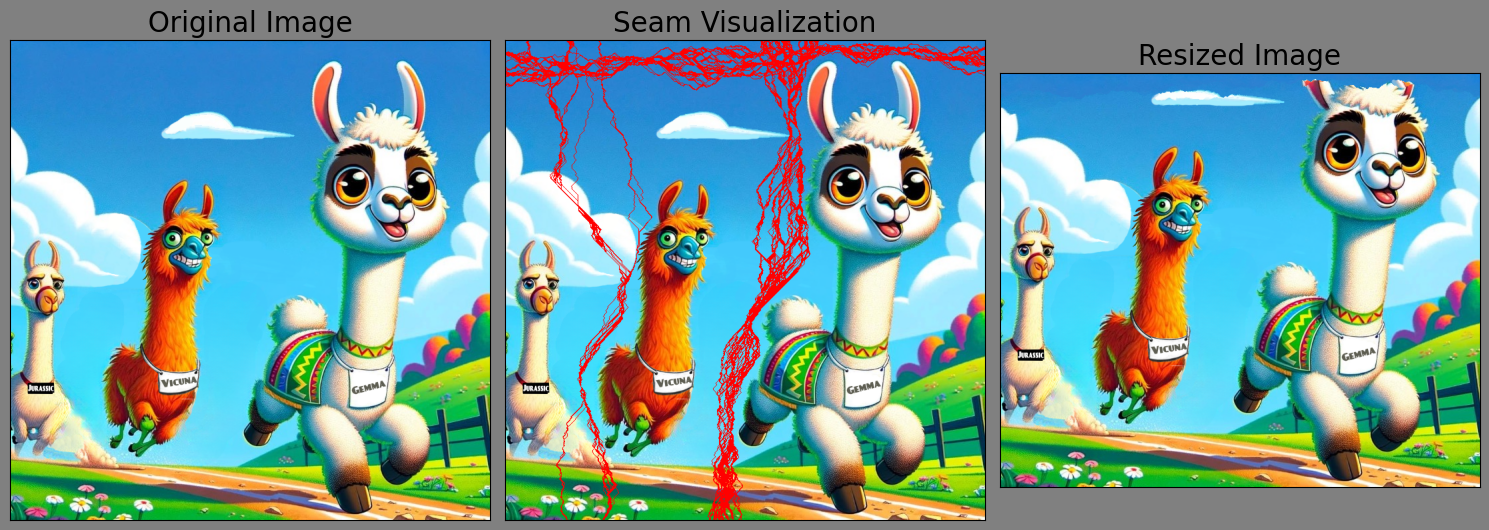

In [450]:
plot_grid(vs_img)

*After the context-aware resizing, the race should be tighter. Think why this makes sense.*

### TODO: Implement the `SCWithObjRemoval` Class for Object Removal (20 points)

We are now going to implement `SCWithObjRemoval` class, and remove each of the characters.

We supply you with binary masks of both Gemma and Vicuna.

**Removing Jurassic is a bonus!**

In [451]:
# TODO: Create a SCWithObjRemoval class
obj_img = SCWithObjRemoval(active_masks=['Vicuna'], img_path=img_path) # ignore PIL's warning if appears. we want our mask to be binary. 

NotImplementedError: TODO: Implement SeamImage.preprocess_masks

In [ ]:
# Disply masks

ax, font_size = init_plt_grid(ncols=len(obj_img.obj_masks) + 1, figsize=(12,12))

ax[0].imshow(obj_img.rgb)
for i,k in enumerate(obj_img.obj_masks):
    ax[i+1].imshow(obj_img.obj_masks[k])

for sp in ax.reshape(-1):
    sp.set_xticks([])
    sp.set_yticks([])

plt.tight_layout()

In [ ]:
# apply active masks on obj_img (and calculate all required matrices)
obj_img.apply_mask()

In [ ]:
# remove Vicuna
%time obj_img.seams_removal_vertical(155)

In [ ]:
# display result grid
plot_grid(obj_img)

removing Gemma:

In [ ]:
obj_img.reinit(active_masks=['Gemma'])

In [ ]:
obj_img.apply_mask()

# remove Gemma
%time obj_img.seams_removal_vertical(250)

In [ ]:
# display result grid
plot_grid(obj_img)

#### Bonus I: Removing Jurassic (2 points)

Create a mask for Jurassic and display the result bellow

In [ ]:
obj_img_j = SCWithObjRemoval(active_masks=['Jurassic'], img_path=img_path)

In [ ]:
obj_img_j.apply_mask()

# remove Jurassic
%time obj_img_j.seams_removal_vertical(120)

In [ ]:
show_image(obj_img_j.seams_rgb)

#### Bonus: Seam Carving for Image Enlarging (7 points)
As discussed in the unit, seam's "importance" can be also used to enlarge images, simply duplicating the least important seam every time.

Implement `VerticalSeamImage.seams_addition`:
* You may use wrapper functions for vertical/horizontal (same as in the removal process)
* Paint the added seams in green
* To get full bonus credit, use the llamas' example image and plot the visualization after: i) adding 50 vertical seams. ii) adding 50 horizontal seams
* For this part you can add the necessary cells bellow (for plotting)

In [ ]:
vs_img.reinit()
try:
    vs_img.seams_addition_horizontal(50)
except NotImplementedError as e:
    print(e)

### Method Comparison and Recaling (10 points)

In this final section you will be comparing the two methods with bilinear interpolation (a rescaling algorithm, implemented for you).

In [ ]:
from utils import bilinear

scale_factors = [[.6, 1.], [1., .6]] # -> scale_factors[i,0] for height and scale_factors[i,1] for width

In [ ]:
img_path = 'images/palawan2.jpg'

img = read_image(img_path)
print(img.shape)
show_image(img.astype('int'));

In [ ]:
aspect_ratio = img.shape[1] / img.shape[0] # -> claculate the image AR
print('Aspect ratio:', aspect_ratio)

##### TODO: Implement `scale_to_shape` and `resize_seam_carving` (5 + 5 points)
* `scale_to_shape` takes an image shape (y,x) and $f_y,f_x$ scale factors and returns the new image shape.
* `resize_seam_carving` takes a SeamImage instance along with the new shape and applies the resize.

In [ ]:
data = {}
vs_img = VerticalSeamImage(img_path)

for s in scale_factors:
    orig_shape = np.asarray(img.shape[:-1])
    new_shape = scale_to_shape(orig_shape, s)
    bi_resized_rgb = bilinear(img, new_shape)
    vs_resized_rgb = resize_seam_carving(vs_img, (orig_shape, new_shape))
    data[str(s)] = (bi_resized_rgb, vs_resized_rgb)

In [ ]:
# Resluts comparison

ax, font_size = init_plt_grid(3, 2, figsize=(20,15))


ax[0,0].set_title(f'Scale Factor {scale_factors[0]}', **font_size)
ax[0,1].set_title(f'Scale Factor {scale_factors[1]}', **font_size)

ax[0,0].set_ylabel('Original', **font_size)
ax[1,0].set_ylabel('Bilinear Interp.', **font_size)
ax[2,0].set_ylabel('C-SC', **font_size)
# ax[3,0].set_ylabel('V-SC', **font_size)


ax[0,0].imshow(img.astype('uint'))
ax[1,0].imshow(data[str(scale_factors[0])][0])
ax[2,0].imshow(data[str(scale_factors[0])][1])
# ax[3,0].imshow(data[str(scale_factors[0])][2])

ax[0,1].imshow(img.astype('uint'))
ax[1,1].imshow(data[str(scale_factors[1])][0])
ax[2,1].imshow(data[str(scale_factors[1])][1])
# ax[3,1].imshow(data[str(scale_factors[1])][2])


for sp in ax.reshape(-1):
    sp.set_xticks([])
    sp.set_yticks([])

plt.tight_layout()


### Discussion and Conclution

##### Discussion
* DP matrices: pay attention to the DP matrices you calculated. They should be give an intuition of the correcness of your implemetions.
* Seam Visualization: There are two noticible phenomanons when looking at them: i) Some seams might not be complete (side to side). Why is it? which of the seams is it likely to occur? ii) The chosen seams tend to avoid "important" content (look at the dices, the class etc,. Is it a positive characteristic?
* Rescaling and resizing: It can bee seen that Resizing images preserves geometry of objects, which emphisizes the adavantages of the content-awareness of Seam Carving. On the other hand, rescaling modifies existing image pixels and thus might affect its content.

##### Conclution
* We have implemented two applications of the Seam Carving algorithms
* We have comared Seam Carving to none content-aware methods and discussed their pros/cons
* This implementation can be extended into some possible directions:
    * Removing Objects while keeping the same image size
    * Adding objects into images
    
*Side note (and a clue to the first bonus)*: **This image was generated by AI.**

*Tip*: **For future use, creating masks for every object we want to remove is complex. See [Sematic Segmenetaion](https://paperswithcode.com/task/semantic-segmentation#:~:text=Semantic%20Segmentation%20is%20a%20computer,a%20specific%20class%20or%20object) for more information on how to create these more efficiently.**

**Good Luck!**
